In [14]:
#!pip install --upgrade ../../tradeframework
#!pip install --upgrade ~/Development/repos/quantutils

# import utilities
from quantutils.api.datasource import MarketDataStore
from quantutils.api.auth import CredentialsStore
import quantutils.dataset.pipeline as ppl

#import tradeframework
from tradeframework.api import Derivative, Portfolio, Optimizer, Model, TradeEnvironment, TradeEngine, AssetInfo
from tradeframework.environments import SandboxEnvironment, SandboxContext, ZiplineEnvironment
from tradeframework.models import PreOpenMomentum

# Development
import pandas as pd
import numpy as np

%matplotlib inline

In [15]:
## Get Market Data

mds = MarketDataStore("../../marketinsights-data/datasources")

assets = {
    "markets": ["DOW"],
    "start": "2016-07-06",
    "end": "2018-08-01"
}

#assets = {
#    "markets": ["DOW"],
#    "start": "2013-01-01",
#    "end": "2018-08-01"
#}

markets = mds.loadMarketData(assets, "H")
ts = ppl.removeNaNs(markets["DOW"])
ts.index = ts.index.tz_convert("US/Eastern")

Loading DOW data from WallSt-hourly in tradefair.hdf
Resampling to H periods
Resampling to H periods
Resampling to H periods
Merging data...
Loading DOW data from D&J-IND in finam.hdf
Resampling to 5min periods
Resampling to H periods
Resampling to H periods
Merging data...


In [6]:
class RetraceDailyMove(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def handleData(self, context, assetInfo):
        Model.handleData(self, context, assetInfo)
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])

        if (self.start is not None):
            scope = ppl.cropTime(assetInfo.values["Open"], self.start, self.end)
        else:
            scope = assetInfo.values["Open"]
            
        sig = signals.loc[scope.index][1:]
        sig["bar"] = np.negative(np.sign(np.diff(scope)))
        signals.loc[sig.index] = sig

        return self.getDerivativeInfo(context, [assetInfo], [signals])

In [7]:
class Momentum(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def handleData(self, context, assetInfo):
        Model.handleData(self, context, assetInfo)
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])

        if (self.start is not None):
            scope = ppl.cropTime(assetInfo.values, self.start, self.end)
        else:
            scope = assetInfo.values
            
        sig = signals.loc[scope.index][1:]
        sig["bar"] = np.sign((scope["Close"] - scope["Open"]).values[:-1])
        signals.loc[sig.index] = sig

        return self.getDerivativeInfo(context, [assetInfo], [signals])

In [8]:
class MeanReversion(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def handleData(self, context, assetInfo):
        Model.handleData(self, context, assetInfo)
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])

        if (self.start is not None):
            scope = ppl.cropTime(assetInfo.values, self.start, self.end)
        else:
            scope = assetInfo.values
            
        sig = signals.loc[scope.index][1:]
        sig["bar"] = np.negative(np.sign((scope["Close"] - scope["Open"]).values[:-1]))
        signals.loc[sig.index] = sig

        return self.getDerivativeInfo(context, [assetInfo], [signals])

In [3]:
bEnv = SandboxEnvironment("TradeFair")
p = bEnv.createPortfolio("Baseline", optimizer=bEnv.createOptimizer("EqualWeightsOptimizer", "EqualWeights"))
p.addModel(bEnv.createModel( "BuyAndHold", "D3-BuyAndHold", args=("15:00", "16:00")))
#p.addModel(MeanReversion("MR-BL", bEnv, "12:00", "13:00" ))
#p.addModel(bEnv.createModel( "BuyAndHold", "D3-BuyAndHold"))
baseline = bEnv.handleData({}, AssetInfo("DOW", ts)).assets[0]

In [53]:
env = SandboxEnvironment("TradeFair")
context = {}

#opt = env.createOptimizer("KellyOptimizer", "KellyOpt", opts={"window":20*24, "weight":.05})
opt = env.createOptimizer("EqualWeightsOptimizer", "EqualWeights", opts={"weight":1.0})
p = env.createPortfolio("MyPortfolio", optimizer=opt)

#p.addModel(RetraceDailyMove("RDM1", env, "12:00", "13:00" ))
#p.addModel(RetraceDailyMove("RDM2", env, "13:00", "14:00" ))
#p.addModel(RetraceDailyMove("RDM3", env, "14:00", "15:00" ))
#p.addModel(RetraceDailyMove("RDM4", env, "15:00", "16:00" ))

#p.addModel(MeanReversion("MR1", env, "09:00", "10:00" ))
#p.addModel(MeanReversion("MR2", env, "10:00", "11:00" ))
#p.addModel(MeanReversion("MR3", env, "11:00", "12:00" ))
#p.addModel(MeanReversion("MR4", env, "12:00", "13:00" ))
#p.addModel(MeanReversion("MR5", env, "13:00", "14:00" ))
#p.addModel(MeanReversion("MR6", env, "14:00", "15:00" ))
#p.addModel(MeanReversion("MR7", env, "15:00", "16:00" ))
#p.addModel(Momentum("MOM1", env, "12:00", "13:00"))

#p.addModel(env.createModel( "PreOpenMomentum", "D1-PreOpenMomentum" ))

#p.addModel(env.createModel( "BuyAndHold", "D2-BuyAndHold" ))

#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold7", args=("09:00", "10:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold6", args=("10:00", "11:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold5", args=("11:00", "12:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold4", args=("12:00", "13:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold3", args=("13:00", "14:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold2", args=("14:00", "15:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold1", args=("15:00", "16:00")))

#p.addModel(env.createModel( "SellAndHold", "D4-SellAndHold", args=("15:00", "16:00")))
threshold = 0
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBoosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBoosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_SwitchedOrder_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', 'bdfa91432d64e63fc528869163a8b3fb', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_SwitchedOrder_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', 'bdfa91432d64e63fc528869163a8b3fb', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_LongRun_SPY", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_LongRun_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '9a23dcf38b04cccf8a28381ea013dc7f', threshold)))

agg = [{
    'training_run_id':'012624ea38cf5f8694ed0fcff405f077',
    'datasets': ['4234f0f1b6fcc17f6458696a6cdf5101', '3231bbe5eb2ab84eb54c9b64a8dcea55']
}]

p.addModel(env.createModel( "MIAggregateModel", "ML-OneStepAhead_Agg", args=(CredentialsStore(), agg, "vote_unanimous_all", threshold)))

# Feed data into the portfolio
#for index in range(0, len(ts)):
#env.handleData(0, ts[:index+1])
dInfo = env.handleData(context, AssetInfo("DOW", ts)) # TODO this should be "getDerivative" or "backTest"
print("Done")

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/dataset/pipeline.py:89: RuntimeWarning: invalid value encountered in greater_equal
  a[(labels>=threshold).flatten()] = labels[labels>=threshold]
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/dataset/pipeline.py:90: RuntimeWarning: invalid value encountered in greater
  b[((1-labels)>threshold).flatten()] = 1 - labels[(1-labels)>threshold]


Done


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f706657b748>)

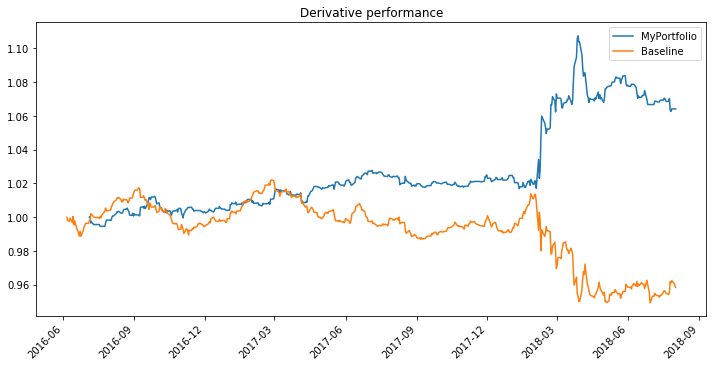

In [54]:
import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(dInfo.assets[0], baseline, includeComponents=False, includePrimary=True, log=False)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f70668a7780>)

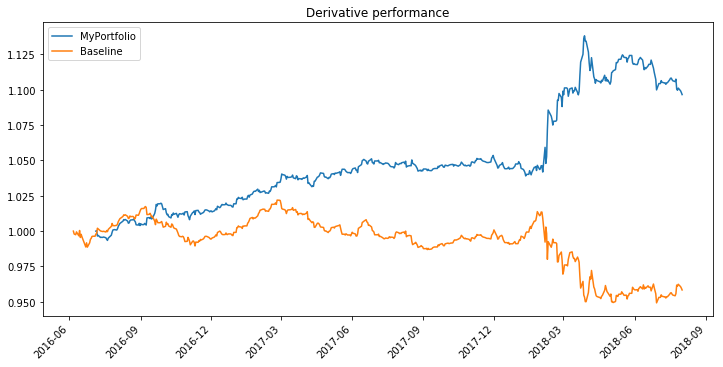

In [52]:
import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(dInfo.assets[0], baseline, includeComponents=False, includePrimary=True, log=False)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7066939d68>)

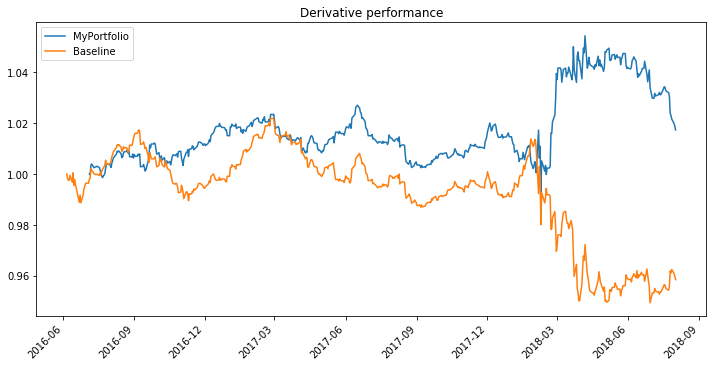

In [46]:
import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(dInfo.assets[0], baseline, includeComponents=False, includePrimary=True, log=False)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f709005d908>)

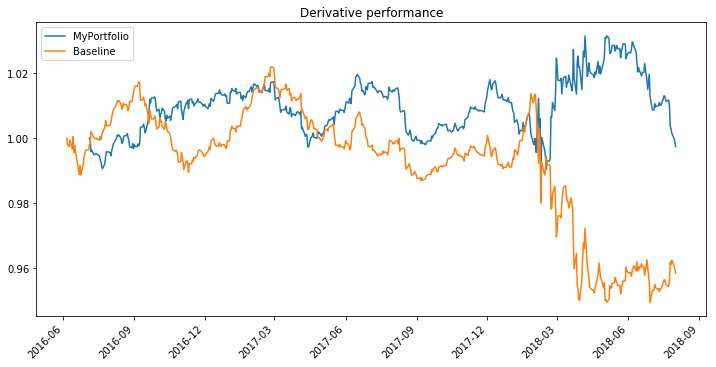

In [21]:
import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(dInfo.assets[0], baseline, includeComponents=False, includePrimary=True, log=False)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f70929b87f0>)

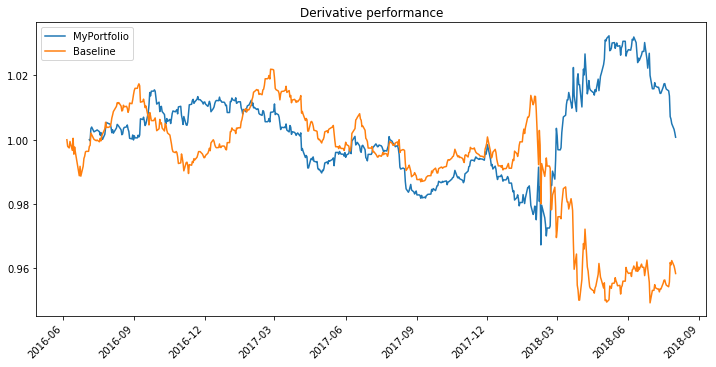

In [17]:
import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(dInfo.assets[0], baseline, includeComponents=False, includePrimary=True, log=False)

No handles with labels found to put in legend.


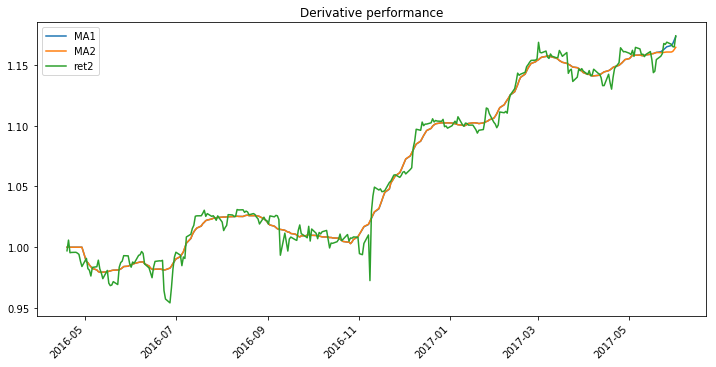

In [13]:
import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
fig, ax = trader.plot(dInfo.assets[0], includeComponents=False, includePrimary=False, log=False)

# Add Moving Average
import quantutils.core.timeseries as tsUtils
period = 20
offset = period//2
ret =  (trader.getPeriodReturns(dInfo.assets[0].returns) + 1).resample('B').agg('prod')-1
ret2 = np.cumprod((ret + 1))
ma2 = pd.DataFrame(tsUtils.DMA(ret2, period, -offset), ret2.index)
ma2[ma2==0] = 1#ret2.values[ma2.values.flatten()==0].tolist()
ret3 = np.log(ret+1)
ma1 = pd.DataFrame(tsUtils.DMA(ret3, period, -offset), ret3.index)
ma1 = np.exp(ma1)
ma1.iloc[period-offset-1] = ma2.iloc[period-offset-1]
ma1 = np.cumprod(ma1)

#ma3 = pd.DataFrame(tsUtils.DMA(ret, period, -offset), ret.index) + 1
#ma3.iloc[period-offset-1] = ma2.iloc[period-offset-1]
#ma3 = np.cumprod(ma3)

ax.plot(ma1, label="MA1")
ax.plot(ma2, label="MA2")
#ax.plot(ma3, label="MA3")
ax.plot(ret2,label="ret2")
ax.legend(loc='best')
fig.canvas.draw()

In [17]:
ma1[-10:]

,0
Date_Time,
2017-05-19 00:00:00-04:00,1.1603836991
2017-05-22 00:00:00-04:00,1.1609782072
2017-05-23 00:00:00-04:00,1.1618819314
2017-05-24 00:00:00-04:00,1.1628237997
2017-05-25 00:00:00-04:00,1.1639647959
2017-05-26 00:00:00-04:00,1.1650591218
2017-05-29 00:00:00-04:00,1.1660566943
2017-05-30 00:00:00-04:00,1.1676922936
2017-05-31 00:00:00-04:00,1.1704739593


In [16]:
ma2[-10:]

,0
Date_Time,
2017-05-19 00:00:00-04:00,1.1603687214
2017-05-22 00:00:00-04:00,1.1602050363
2017-05-23 00:00:00-04:00,1.1602958285
2017-05-24 00:00:00-04:00,1.1603789264
2017-05-25 00:00:00-04:00,1.1606079072
2017-05-26 00:00:00-04:00,1.1607409958
2017-05-29 00:00:00-04:00,1.1607134486
2017-05-30 00:00:00-04:00,1.1612306797
2017-05-31 00:00:00-04:00,1.1628189826


In [14]:
ma = tsUtils.MA(ret2, period)
ma[:21]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.98809951,
       0.9872487 ])

In [12]:
def MA(values, period):
    ma = np.zeros(len(values)) 
    for n in range(period-1,len(ma)):
        ma[n] = np.mean(values[n-(period-1):n])
    #ma[0:period] = 0 #[ma[period-1]]*period
    return ma

In [102]:
import numpy as np 
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    result = result / max(result)
    return result

def ac_win(dRet, window=20, lag=1):
    ac = [0] * (window//2)
    for i in range(window, len(dRet)):
        sample = dRet[i-window:i]
        ac.append(autocorr(sample)[lag])
    return ac

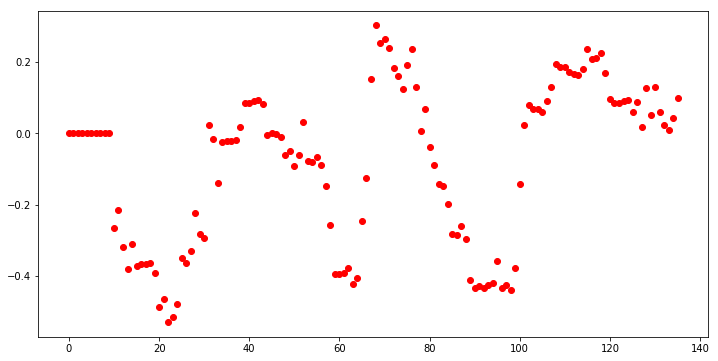

In [120]:
#pyplot.plot(ac_win(dRet))
pyplot.plot(ac_win(x, lag=1), 'ro')
pyplot.show()

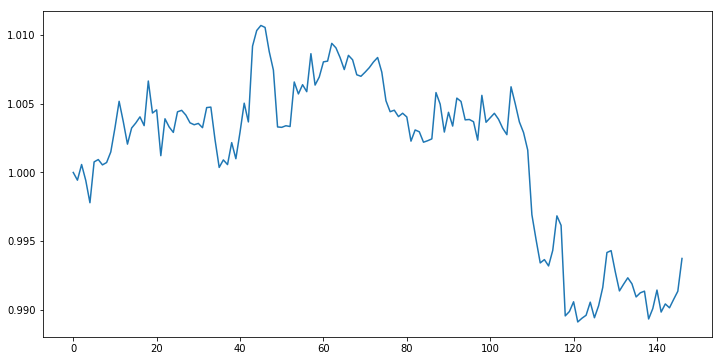

In [121]:

from matplotlib import pyplot
pyplot.plot(tInfo.values[:,0]/10000)
pyplot.show()

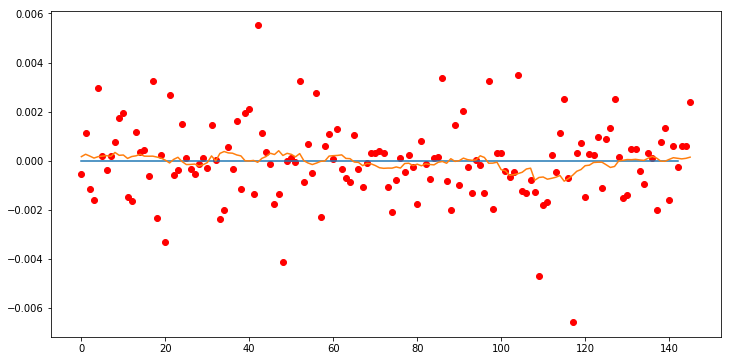

In [122]:

from matplotlib import pyplot
x = np.diff(tInfo.values[:,0]/10000)
lags = 20
ma = np.convolve(x, np.ones((lags,))/lags, mode='same')
pyplot.plot(x,'ro')
pyplot.plot([0] * len(x1))
pyplot.plot(ma)
pyplot.show()

In [119]:
import statsmodels.api as sm

x = (tInfo["TradeFair_Portfolio"]["Capital"]["Open"].diff()/tInfo["TradeFair_Portfolio"]["Capital"]["Open"])[1:]

x

Date_Time
2016-04-20 12:00:00-04:00   -0.0005607062
2016-04-21 12:00:00-04:00    0.0011370159
2016-04-22 12:00:00-04:00   -0.0011594943
2016-04-25 12:00:00-04:00   -0.0016223449
2016-04-26 12:00:00-04:00    0.0029649280
                                 ...     
2016-11-03 12:00:00-04:00    0.0005943157
2016-11-04 12:00:00-04:00   -0.0002835712
2016-11-07 12:00:00-05:00    0.0006183810
2016-11-08 12:00:00-05:00    0.0005975222
2016-11-09 12:00:00-05:00    0.0023969866
Name: Open, Length: 146, dtype: float64

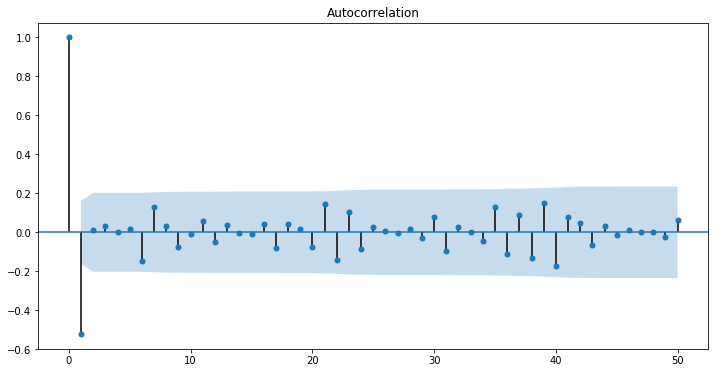

(-2.5611866900520868,
 0.10128742071727043,
 0,
 145,
 {'1%': -3.476273058920005,
  '5%': -2.881687616548444,
  '10%': -2.5775132580261593},
 -2009.1837538474956)

In [123]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plot_acf(np.diff(x), lags=50)
pyplot.show()
adfuller(ma)

In [124]:
import statsmodels.api as sm

# Fit the model
#x = x - x.mean()
mod_data = sm.tsa.MarkovAutoregression(x, k_regimes=2, order=1, trend='nc', switching_variance=True)
res_data = mod_data.fit()

res_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                  145
Model:             MarkovAutoregression   Log Likelihood                 738.310
Date:                  Fri, 27 Jul 2018   AIC                          -1464.620
Time:                          17:18:15   BIC                          -1446.760
Sample:                               0   HQIC                         -1457.363
                                  - 145                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.926e-07        nan        nan        nan         nan         nan
ar.L1         -0.2555      0.104     -2.461      0.014      -0.459      -0.052
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.485e-06   5.23e-07      6.660      0.000    2.46e-06    4.51e-06
ar.L1         -0.0173      0.117     -0.148      0.882      -0.246       0.211
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.3326      0.105      3.177      0.001       0.127       0.538
p[1->0]        0.2930      0.092      3.177      0.001       0.112       0.474
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

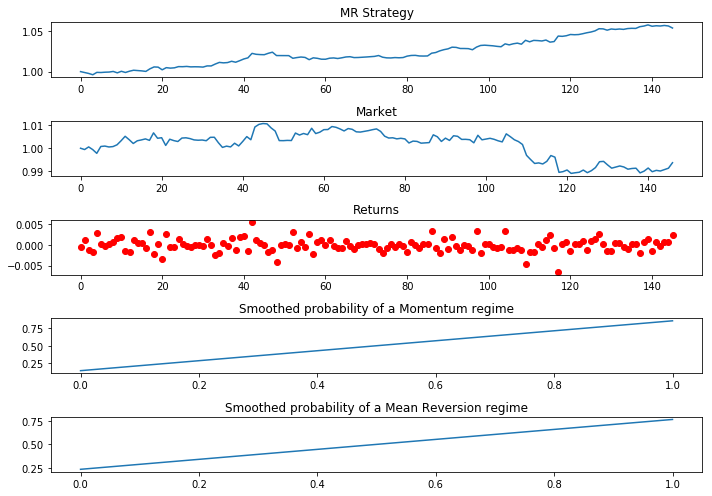

In [125]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, figsize=(10,7))

bInfo = bEnv.getTradingInfo(context, baseline, startCapital=1)
ax = axes[0]
ax.plot(bInfo.values[:,0])
ax.set(title='MR Strategy')

ax = axes[1]
ax.plot(tInfo.values[:,0]/10000)
ax.set(title='Market')

ax = axes[2]
ax.plot(x, 'ro')
ax.set(title='Returns')

ax = axes[3]
ax.plot(res_data.filtered_marginal_probabilities[0])
ax.set(title='Smoothed probability of a Momentum regime')

ax = axes[4]
ax.plot(res_data.filtered_marginal_probabilities[1])
ax.set(title='Smoothed probability of a Mean Reversion regime')

#ax = axes[4]
#ax.plot(res_data.filtered_marginal_probabilities[2])
#ax.set(title='Smoothed probability of a High Mean Reversion regime')

fig.tight_layout()

In [107]:
res_data.expected_durations

array([6.60991885, 4.72710827])

In [98]:
def ema(sample, weight=0.2):
    global avg
    avg = (sample * weight) + ((1-weight)*avg)
    #avg = (sample / 14.0) + (13.0 * avg /14.0)
    return avg

<BarContainer object of 20 artists>

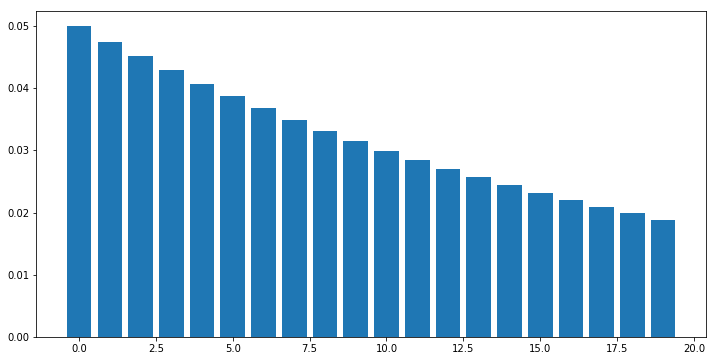

In [100]:
x = 2 / (20 + 1)
x = 0.05
plt.bar(range(0,20), [x*(1-x)**n for n in range(0,20)])

In [101]:
sum([x*(1-x)**n for n in range(0,20)])

0.6415140775914574

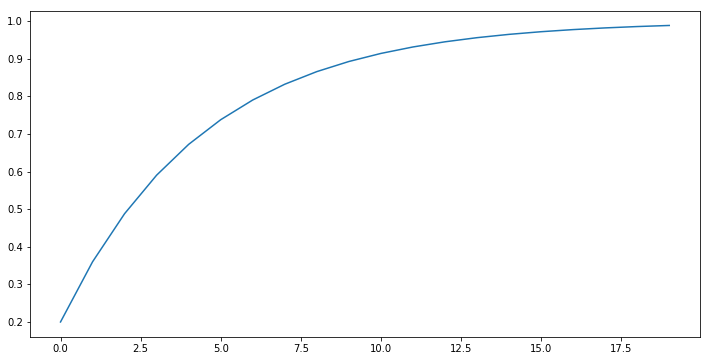

In [99]:
avg = 0
plt.plot([ema(x) for x in np.ones(20)])